#VenPy Basic Usage

Here we will show the basic usage of VenPy. This short tutorial will cover:

 1. Installing the package
 2. Loading compiled Vensim models
 3. Setting and getting model constants
 5. Running models and retrieving results
 4. 'Replacing' model components with Python functions
 6. Working with subscripted variables


##1. Installing VenPy

 * VenPy can be installed from source at the project [home page](https://github.com/pbreach/venpy) by first downloading the source files clicking "Download Zip", or by cloning the project to your local machine.
 
 * After the files have been downloaded they can be extracted. From here, navigate to the project directory on your machine via `$ cd /path/to/directory`. 
 After navigating the the directory we can run the setup script via 
 `$ python setup.py install`
 * The package will now be installed to your default version of Python which needs to be Windows 32-bit for it to work with Vensim. If your default Python is not Windows 32-bit the command `$ python setup.py` can be modified to point to the 32-bit version by instead using `$ /path/to/python.exe setup.py install`
 
 Now you should hopefully be able to: 

In [1]:
import venpy

##2. Loading Vensim Models

The Vensim DLL allows you to load in *compiled* Vensim models with the .vpm extension. This can be obtained by [publishing](https://www.vensim.com/documentation/index.html?usr19_saving_to_a_binary_file.htm) the Vensim model that needs to be loaded. Here we will be using the `simple.vpm` model in the `examples` directory. 

![alt text](https://github.com/pbreach/venpy/models/simple.png "Simple Model Stock & Flow")

In [2]:
model = venpy.load('../models/simple.vpm')

After the model has been load we can get some information of the names and types of model variables using the `names` method:

In [3]:
model.names

{'aux': ['Outflow', 'SAVEPER'],
 'constant': ['Characteristic Time',
  'FINAL TIME',
  'INITIAL TIME',
  'TIME STEP'],
 'constraint': [''],
 'data': [''],
 'game': ['Outflow'],
 'group': ['.Control', '.simple'],
 'init': [''],
 'level': ['Stock'],
 'lookup': [''],
 'sub_constant': [''],
 'sub_range': [''],
 'test_input': [''],
 'time_base': ['Time']}

##3. Setting and Getting Model Constants

One of the main features associated with using the Vensim DLL is the ability to retrieve and set model constants prior to simulation. This will help to facilitate batch processing of models for various sensitivity analyses.

This functionality is incorporated in VenPy through the `__setitem__` and `__getitem__` methods, and can be used as follows:

In [4]:
current = model['Characteristic Time']
print("Characteristic Time is initially %d" % current)

model['Characteristic Time'] = 20
new = model['Characteristic Time']
print("Characteristic Time is now %d" % model['Characteristic Time'])

Characteristic Time is initially 5
Characteristic Time is now 20


Note that if the Vensim variable is *not* a model constant, and is accessed in any way *outside* of a simulation and error will be thrown.

In [5]:
print model['Stock']

KeyError: "Cannot get 'level' outside simulation."

##4. Running Models and Retrieving Results

After a model has been loaded, it can be run by using the `run` method, which will tell Vensim to run the loaded model.

In [6]:
model.run()

By default, VenPy will use the name `Run` to label the run, as well as the resulting output file `Run.vdf`. We can change this by passing the `runname` argument to the `run method`.

In [7]:
model.run(runname='First Run')

This will create an output file in the same directory as the compiled Vensim model labelled, `First Run.vdf`. This output file can be used to view the results in Vensim, but if we can to run a model multiple times and process the data further, we can retrieve the results as a Python dictionary.

In [8]:
model.result()

{'Outflow': [1.0,
  0.949999988079071,
  0.9024999737739563,
  0.8573749661445618,
  0.8145062327384949,
  0.7737809419631958,
  0.7350918650627136,
  0.6983372569084167,
  0.6634203791618347,
  0.6302493810653687,
  0.5987368822097778],
 'SAVEPER': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'Stock': [20.0,
  19.0,
  18.049999237060547,
  17.147499084472656,
  16.290124893188477,
  15.475618362426758,
  14.701837539672852,
  13.966745376586914,
  13.268407821655273,
  12.604987144470215,
  11.974738121032715]}

By default, this will retrieve all model variables that are of type `Level`, `Auxiliary`, and `GAME`. For finer control we can specify the variable names that we want by passing a list of variable names to the `result` method through the `varnames` keyword argument.

In [9]:
model.result(varnames=['Stock'])

{'Stock': [20.0,
  19.0,
  18.049999237060547,
  17.147499084472656,
  16.290124893188477,
  15.475618362426758,
  14.701837539672852,
  13.966745376586914,
  13.268407821655273,
  12.604987144470215,
  11.974738121032715]}

##5. 'Replacing' Model Components

Vensim offers a [large selection of functions](https://www.vensim.com/documentation/index.html?22300.htm) to be used in Vensim equations. However, in some cases there may be a particular analysis that requires some type of functionality not present in the Vensim simulation software. These could include (but are not limited to):

 * Genetic optimization algorithms
 * Specialized statistical models
 * Machine learning
 * Ability to interact with external modeling programs
 
Luckily, Python has many built-in features and third-party projects (such as this one) that can do these things really well.

To take advantage of this, we can 'replace' a specific Vensim model component by diverting input and output to and from a Python function during a Vensim 'Gaming' simulation. The function must be defined with no arguments, and return a valid input to the target model variable. **Target variable must set as an Auxiliary variable with subtype Gaming to set during Gaming simulation!** 

In this case we will replicate the Vensim equation with an equivalent Python function, as well as print out the current model time.

In [10]:
def outflow():
    print model['Time']
    return model['Stock'] / model['Characteristic Time']

We can set this function to the target variable `Flow`, effectively 'replacing' this component with the Python function `outflow` that we've defined

In [11]:
model['Outflow'] = outflow

Now, if we run the model you'll see that the same output is obtained as before with the Vensim equation, and we also see that current model time being printed at every time step

In [12]:
model.run()

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0


In [14]:
model.result()

{'Outflow': [1.0,
  1.0,
  0.949999988079071,
  0.9024999737739563,
  0.8573749661445618,
  0.8145062327384949,
  0.7737809419631958,
  0.7350918650627136,
  0.6983372569084167,
  0.6634203791618347,
  0.6302493810653687],
 'SAVEPER': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'Stock': [20.0,
  19.0,
  18.049999237060547,
  17.147499084472656,
  16.290124893188477,
  15.475618362426758,
  14.701837539672852,
  13.966745376586914,
  13.268407821655273,
  12.604987144470215,
  11.974738121032715]}

Note that when were only able to get and set model *constants* outside of the simulation previously but now we are interacting with a `Stock`. When a callable object (such as a function) is set to a model variable, VenPy knows to run the simulation as a `GAME` where interaction with other variable types is allowed in Vensim. **This will cause the model to run at a slower rate compared to when only constants are set prior to simulation.** 

If modifying model constants prior to simulation is only required it is recommended to use the previous method as opposed to 'replacing' the model component with a function.

##6. Working with Subscripts

Subscripting is a key feature in Vensim for replicating model structure for up to 8 dimensions. The VenPy allows for interacting with *fully* subscripted variables in the same way that we've shown for non-subscripted variables. However, by using VenPy we can also deal with *subscript ranges*. This allows us to interact with subscripted variables with `numpy` arrays.

As an example, let's say we have the system as before, but now we have 9 stocks which are categorized by their type [A,B,C] and flow structure [D, E, F] as in the `sub_simple.mdl` in the `examples` directory. We follow the same steps as before to obtain a published Vensim model `sub_simple.vpm`. 

In [3]:
model = venpy.load("../models/sub_simple.vpm")

We can chose to set individual elements of a constant prior to simulation just as before, by using the *fully* subscripted variable name as follows,

In [4]:
model['Characteristic Time[A,D]'] = 10

But using VenPy we can also set subscript ranges by passing a numpy array of the same shape as the subscript range to be set.

In [5]:
import numpy as np

In [6]:
model['Characteristic Time[type,D]'] = np.array([10, 15, 20])

When can use any mix of subscript ranges and subscript elements as long as they are in the correct order and there are no naming overlaps between elements of different ranges.

In [7]:
print model['Characteristic Time[type, structure]']
print model['Characteristic Time[A, structure]']

[[ 10.   3.   4.]
 [ 15.   6.   7.]
 [ 20.   9.  10.]]
[ 10.   3.   4.]


This basic concept applies to setting model components as before as long as an array of the correct shape will be set to the target model variable from the Python function

In [8]:
def outflow():
    print model['Time']
    return model['Stock[type, structure]'] / model['Characteristic Time[type, structure]']

In [9]:
model['Outflow[type, structure]'] = outflow

In [12]:
model.run()
result = model.result()

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0


Using `pandas` we can easily view and manipulate the resulting data in the form of a `DataFrame`

In [13]:
import pandas as pd

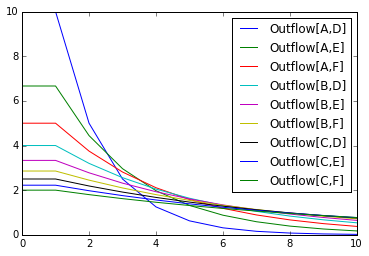

In [17]:
df = pd.DataFrame(result)
df.filter(regex='Outflow').plot()